# Hyperparameter Optimization for LSTM Weather Temperature Prediction

## Setup Google Colab & Install Required Libraries


In [1]:
# Install required libraries
!pip install requests beautifulsoup4 pandas numpy matplotlib meteostat hyperop memory_profiler hyperopt

In [2]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from datetime import datetime, timedelta
from tqdm import tqdm  # for progress bar
import seaborn as sns


## Run the Scraper for 5000 Days

> Ajouter une citation



In [3]:
from datetime import datetime, timedelta
import pandas as pd
from meteostat import Point, Daily

# 1. Define location: Casablanca coordinates
location = Point(33.5667, -7.6667)

# 2. Set time range: last 10000 days
end = datetime.now()
start = end - timedelta(days=10000)

# 3. Fetch daily data
data = Daily(location, start, end)
data = data.fetch()

# 4. Select relevant columns and compute average if needed
# Meteostat daily includes tmin, tmax; avg = (tmin + tmax)/2
data = data[['tmin', 'tmax']].dropna()
data['tavg'] = (data['tmin'] + data['tmax']) / 2

# 5. Save to CSV
data.to_csv('casablanca_last10000days_temps.csv', index_label='date')

print(f"Saved {len(data)} days of data to 'casablanca_last10000days_temps.csv'")


Saved 9402 days of data to 'casablanca_last10000days_temps.csv'


## Data Preparation Pipeline

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Load your Meteostat data
df = pd.read_csv('casablanca_last10000days_temps.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# Use average temperature as target
target = df[['tavg']].values

# Normalize data (LSTMs work better with normalized data)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(target)

#scaler = StandardScaler()  # or RobustScaler, etc.
#scaled_data = scaler.fit_transform(target.values.reshape(-1, 1))

# Create time series sequences
def create_sequences(data, window_size=7, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data)-window_size-forecast_horizon):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+forecast_horizon])
    return np.array(X), np.array(y)

#X, y = create_sequences(scaled_data)

'''# Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)'''

'# Train-test split (70-30)\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.3, shuffle=False\n)'

In [5]:
df.tail(5)

tmin  tmax   tavg
date                         
2025-07-02  22.7  28.7  25.70
2025-07-03  21.6  26.0  23.80
2025-07-04  21.5  26.0  23.75
2025-07-05  21.9  25.4  23.65
2025-07-06  21.4  25.9  23.65

## Bayesian Optimization Setup

In [6]:
import numpy as np
import pandas as pd
import time
import psutil
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from memory_profiler import memory_usage

# Forcer l'utilisation du CPU uniquement (désactive GPU)
tf.config.set_visible_devices([], 'GPU')

# Espace de recherche pour Hyperopt
space = {
    'lstm_layers': hp.choice('lstm_layers', [1, 2]),
    'units': hp.quniform('units', 32, 256, 32),
    'dropout': hp.uniform('dropout', 0.0, 0.5),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'epochs': hp.choice('epochs', [50, 100]),
    'optimizer': hp.choice('optimizer', [
        {'type': 'adam', 'lr': hp.loguniform('adam_lr', np.log(1e-5), np.log(1e-2))},
        {'type': 'sgd', 'lr': hp.loguniform('sgd_lr', np.log(1e-5), np.log(1e-2)),
         'momentum': hp.uniform('sgd_momentum', 0.8, 0.99)},
        {'type': 'rmsprop', 'lr': hp.loguniform('rmsprop_lr', np.log(1e-5), np.log(1e-2))}
    ]),
    'window_size': hp.choice('window_size', [5, 10, 20])
}

# Fonction pour construire le modèle LSTM
def build_model(params):
    model = Sequential()
    model.add(Input(shape=(params['window_size'], 1)))

    for i in range(params['lstm_layers']):
        return_seq = i < params['lstm_layers'] - 1
        model.add(LSTM(int(params['units']), return_sequences=return_seq))
        model.add(Dropout(params['dropout']))

    model.add(Dense(1))

    opt = params['optimizer']
    if opt['type'] == 'adam':
        optimizer = Adam(learning_rate=opt['lr'])
    elif opt['type'] == 'sgd':
        optimizer = SGD(learning_rate=opt['lr'], momentum=opt['momentum'])
    else:
        optimizer = RMSprop(learning_rate=opt['lr'])

    model.compile(optimizer=optimizer, loss='mse')
    return model

def train_and_evaluate(params, X_train, y_train, X_test, y_test):
    model = build_model(params)
    history = model.fit(
        X_train, y_train,
        batch_size=int(params['batch_size']),
        epochs=int(params['epochs']),
        validation_data=(X_test, y_test),
        verbose=0
    )
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_test - y_pred.flatten())**2))
    return rmse, history


def objective(params):
    window_size = params['window_size']
    X, y = create_sequences(scaled_data, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    start_time = time.time()

    # Génération des séquences
    window_size = params['window_size']
    X, y = create_sequences(scaled_data, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Utilisation de memory_profiler
    def wrapped():
        return train_and_evaluate(params, X_train, y_train, X_test, y_test)

    mem_usage, (rmse, history) = memory_usage(wrapped, retval=True, max_usage=True, interval=0.1)

    training_time = time.time() - start_time
    memory_used = mem_usage  # en MB

    metrics = {
      'params': params,
      'optimizer_type': params['optimizer']['type'],  # <-- Add this line
      'rmse': rmse,
      'training_time': training_time,
      'memory_mb': memory_used,
      'stability': np.std(history.history['val_loss'][-10:]),
      'final_val_loss': history.history['val_loss'][-1]
    }

    return {'loss': rmse, 'status': STATUS_OK, 'metrics': metrics}




## Run Optimization & Save Results

In [7]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials
)

# Save all trial results
results = pd.DataFrame([trial['result']['metrics'] for trial in trials.trials])
results.to_csv('hyperopt_results.csv', index=False)

print("Best parameters found:")
print(best)

 1/59 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step                                                      
15/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                              
30/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                              
40/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                              
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                              
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step                                              
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step                                              

 1/59 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step                                                     
18/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                               
34/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                              
52/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                              
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step     

24/59 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step                                              
27/59 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step                                              
29/59 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                              
32/59 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                              
35/59 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step                                              
40/59 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                              
43/59 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                              
46/59 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                              
48/59 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                              
50/59 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                              
53/59 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                              
55/59 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step               

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step                                              

 1/59 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step                                                     
17/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                               
33/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                              
48/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                              
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step                                              
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step                                              

 1/59 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step                                                     
 7/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step                                               
13/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step                                              
19/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step                                              
25/59 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  

21/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                              
31/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                              
41/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                              
51/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                              
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step                                             
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step                                              

 1/59 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step                                                     
12/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                               
21/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                              
31/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                              
40/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                              
49/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step              

In [8]:
import pandas as pd

df = pd.read_csv("hyperopt_results.csv")
optimizer_perf = df.groupby("optimizer_type")[["rmse", "training_time", "memory_mb"]].mean()
print("\nPerformance moyenne par optimiseur :")
print(optimizer_perf)



Performance moyenne par optimiseur :
                    rmse  training_time    memory_mb
optimizer_type                                      
adam            0.156264     349.705708   737.061849
rmsprop         0.155538     231.099634   762.016602
sgd             0.133084     394.665273  1037.337240


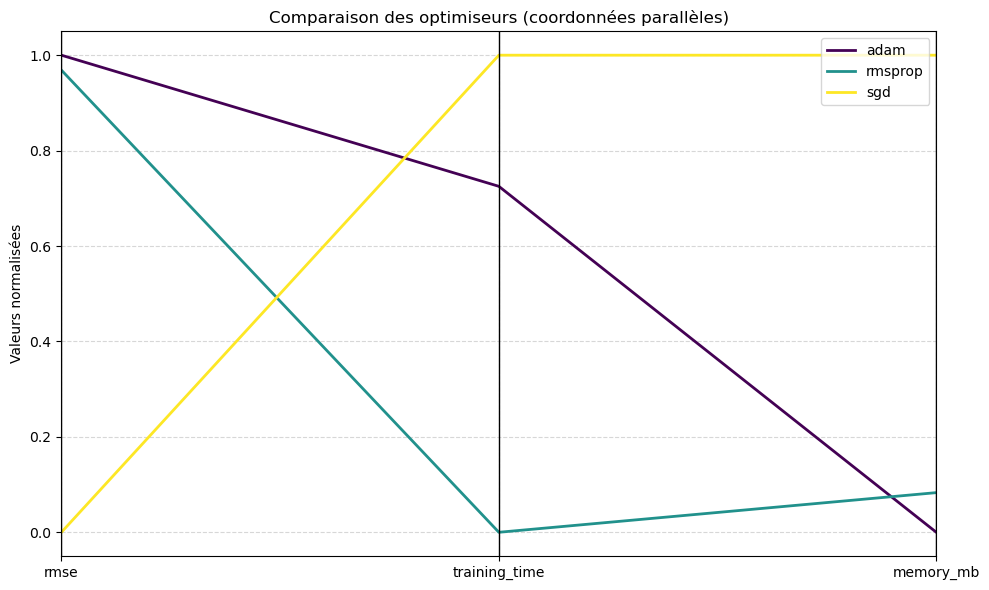

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# Load results
df = pd.read_csv("hyperopt_results.csv")

# Group by optimizer and calculate mean metrics
optimizer_perf = df.groupby("optimizer_type")[["rmse", "training_time", "memory_mb"]].mean().reset_index()

# Optional: Normalize the values for better comparison (especially if scales vary a lot)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized = optimizer_perf.copy()
normalized[["rmse", "training_time", "memory_mb"]] = scaler.fit_transform(
    normalized[["rmse", "training_time", "memory_mb"]]
)

# Plot parallel coordinates
plt.figure(figsize=(10, 6))
parallel_coordinates(normalized, class_column='optimizer_type', colormap='viridis', linewidth=2)

plt.title("Comparaison des optimiseurs (coordonnées parallèles)")
plt.ylabel("Valeurs normalisées")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


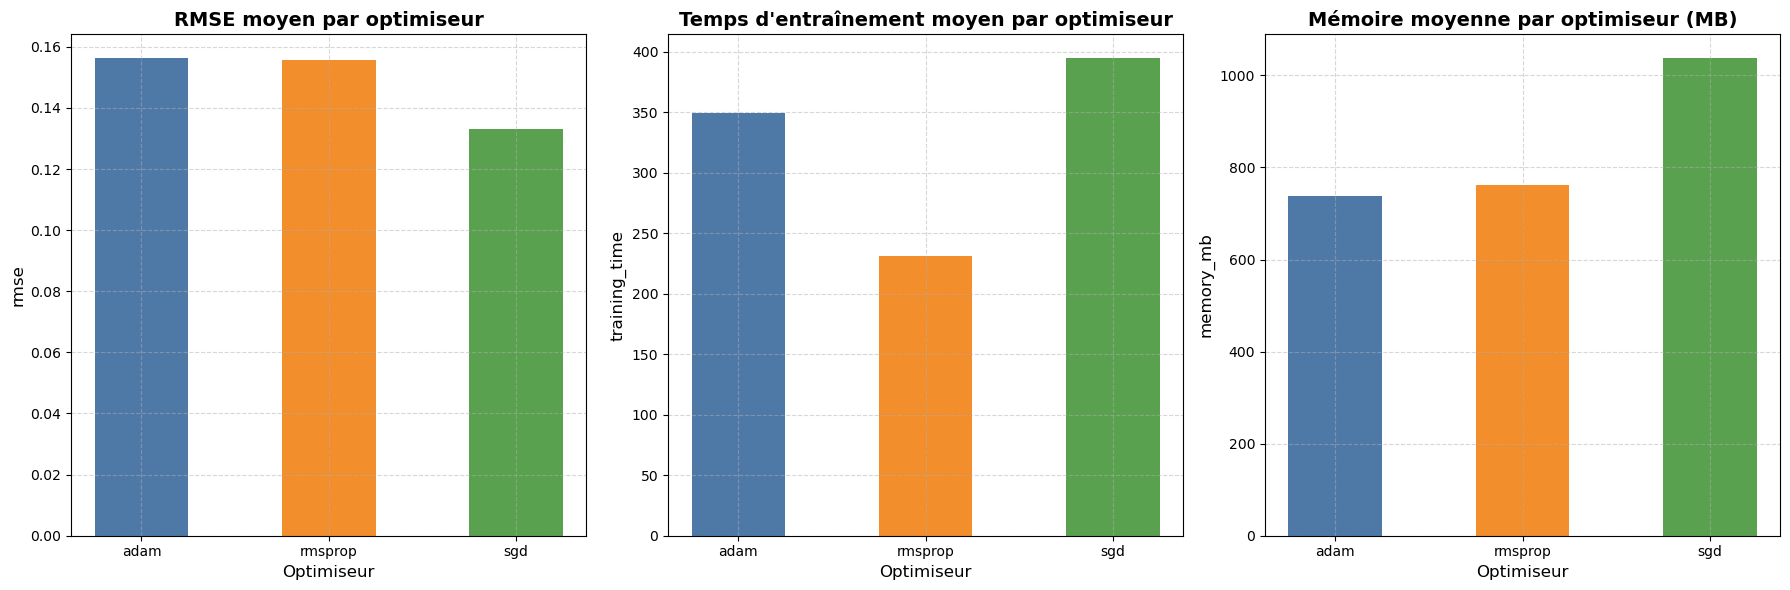

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("hyperopt_results.csv")

# Group by optimizer and calculate mean metrics
optimizer_perf = df.groupby("optimizer_type")[["rmse", "training_time", "memory_mb"]].mean().reset_index()

# Define custom, professional UI-friendly colors
# Using colors from a balanced color palette (Color Universal Design - CUD)
colors = ['#4E79A7', '#F28E2B', '#59A14F']  # A muted blue, orange, and green

# Create subplots for each metric (3 plots in a single row)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define the metrics and titles
metrics = ['rmse', 'training_time', 'memory_mb']
titles = {
    'rmse': 'RMSE moyen par optimiseur',
    'training_time': 'Temps d\'entraînement moyen par optimiseur',
    'memory_mb': 'Mémoire moyenne par optimiseur (MB)'
}

# Plot each metric in its own subplot
for i, metric in enumerate(metrics):
    # Create a bar plot for each metric with professional UI-friendly colors
    axes[i].bar(optimizer_perf['optimizer_type'], optimizer_perf[metric], color=colors, width=0.5)  # Slim bars

    # Title and labels
    axes[i].set_title(titles[metric], fontsize=14, fontweight='bold')
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].set_xlabel('Optimiseur', fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.5)  # Light grid for clarity

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


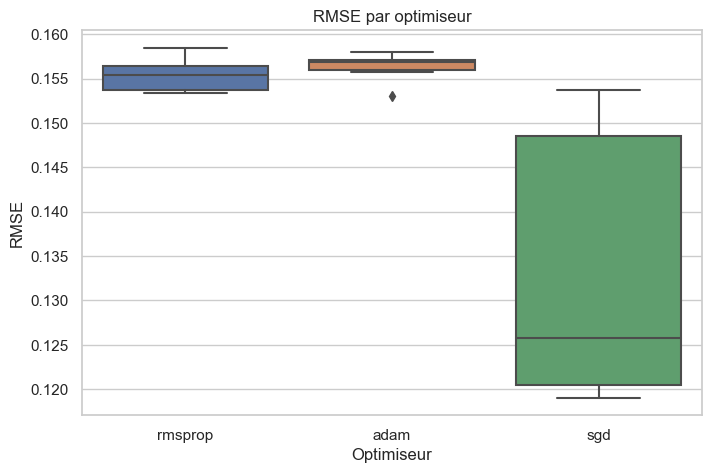

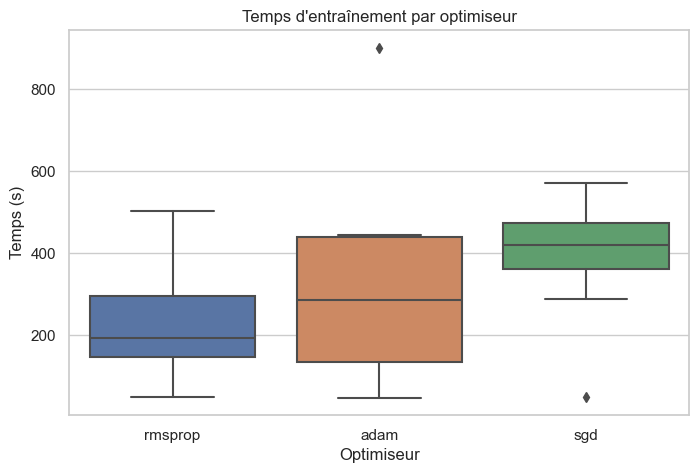

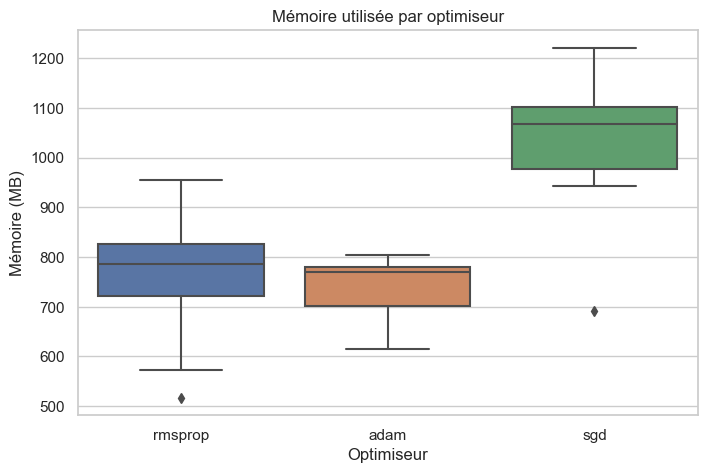

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔁 Remplace ce chemin si ton fichier a un autre nom
df = pd.read_csv("hyperopt_results.csv")

# ✅ S'assurer qu'on ne garde que les lignes valides
df = df[df["optimizer_type"].notna() & df["rmse"].notna()]

# 🎨 Style général
sns.set(style="whitegrid")

# 📊 1. Boxplot RMSE par optimiseur
plt.figure(figsize=(8, 5))
sns.boxplot(x="optimizer_type", y="rmse", data=df)
plt.title("RMSE par optimiseur")
plt.xlabel("Optimiseur")
plt.ylabel("RMSE")
plt.show()

# 📊 2. Boxplot Training Time par optimiseur
plt.figure(figsize=(8, 5))
sns.boxplot(x="optimizer_type", y="training_time", data=df)
plt.title("Temps d'entraînement par optimiseur")
plt.xlabel("Optimiseur")
plt.ylabel("Temps (s)")
plt.show()

# 📊 3. Boxplot Memory par optimiseur
plt.figure(figsize=(8, 5))
sns.boxplot(x="optimizer_type", y="memory_mb", data=df)
plt.title("Mémoire utilisée par optimiseur")
plt.xlabel("Optimiseur")
plt.ylabel("Mémoire (MB)")
plt.show()


## Evaluate & Visualize Results

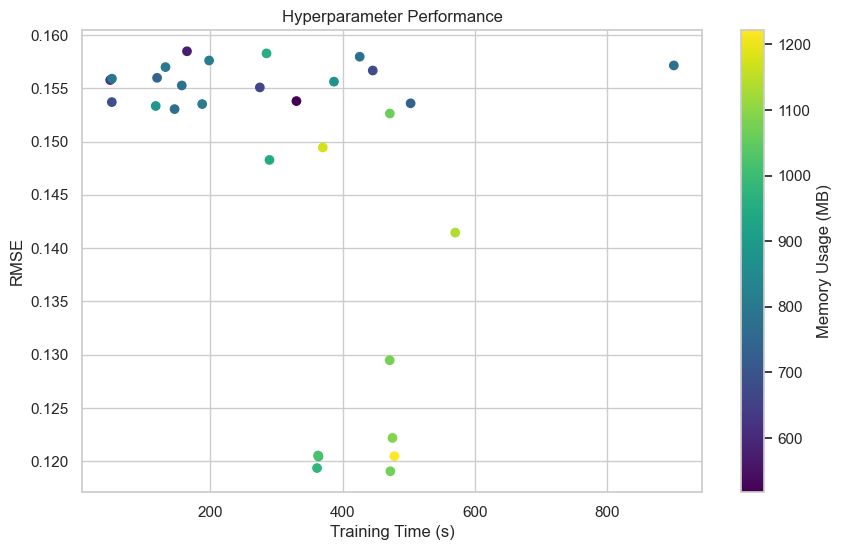

Best trade-off configurations:
Empty DataFrame
Columns: [params, optimizer_type, rmse, training_time, memory_mb, stability, final_val_loss, pareto]
Index: []


In [12]:
import matplotlib.pyplot as plt

# Load results
results = pd.read_csv('hyperopt_results.csv')

# Plot RMSE vs Training Time
plt.figure(figsize=(10, 6))
plt.scatter(results['training_time'], results['rmse'], c=results['memory_mb'], cmap='viridis')
plt.colorbar(label='Memory Usage (MB)')
plt.xlabel('Training Time (s)')
plt.ylabel('RMSE')
plt.title('Hyperparameter Performance')
plt.show()

# Find Pareto front (best trade-offs)
def is_pareto(costs):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
    return is_efficient

pareto_mask = is_pareto(results[['rmse', 'training_time']].values)
results['pareto'] = pareto_mask

# Show Pareto-optimal configurations
print("Best trade-off configurations:")
print(results[results['pareto']].sort_values('rmse').head())

## Re-Analyze Your Results

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your optimization results
results = pd.read_csv('hyperopt_results.csv')

# Display the top 5 best configurations by RMSE
print("Top 5 configurations by RMSE:")
print(results.sort_values('rmse').head(5)[['params', 'rmse', 'training_time', 'memory_mb', 'stability']])

Top 5 configurations by RMSE:
                                               params      rmse  \
23  {'batch_size': 32, 'dropout': 0.30923666643912...  0.119053   
20  {'batch_size': 32, 'dropout': 0.31718844042271...  0.119353   
21  {'batch_size': 32, 'dropout': 0.29571556540815...  0.120443   
29  {'batch_size': 32, 'dropout': 0.25307381680968...  0.120464   
22  {'batch_size': 32, 'dropout': 0.28609822303874...  0.120533   

    training_time    memory_mb  stability  
23     472.176802  1071.875000   0.000049  
20     361.233670   979.019531   0.000048  
21     363.379642   976.117188   0.000029  
29     478.272991  1221.578125   0.000070  
22     362.799025  1021.402344   0.000047  


## Alternative Best Configuration Selection

In [14]:
# Normalize all metrics (lower is better for all in this case)
metrics = ['rmse', 'training_time', 'memory_mb', 'stability']
normalized = (results[metrics] - results[metrics].min()) / (results[metrics].max() - results[metrics].min())

# Create weighted composite score (adjust weights as needed)
weights = {
    'rmse': 0.6,        # Most importance to accuracy
    'training_time': 0.2,
    'memory_mb': 0.1,
    'stability': 0.1
}

results['composite_score'] = (normalized['rmse'] * weights['rmse'] +
                             normalized['training_time'] * weights['training_time'] +
                             normalized['memory_mb'] * weights['memory_mb'] +
                             normalized['stability'] * weights['stability'])

# Get top 3 best overall configurations
best_configs = results.sort_values('composite_score').head(3)
print("\nTop 3 balanced configurations:")
print(best_configs[['params', 'rmse', 'training_time', 'memory_mb', 'stability', 'composite_score']])


Top 3 balanced configurations:
                                               params      rmse  \
20  {'batch_size': 32, 'dropout': 0.31718844042271...  0.119353   
21  {'batch_size': 32, 'dropout': 0.29571556540815...  0.120443   
22  {'batch_size': 32, 'dropout': 0.28609822303874...  0.120533   

    training_time    memory_mb  stability  composite_score  
20     361.233670   979.019531   0.000048         0.157014  
21     363.379642   976.117188   0.000029         0.166932  
22     362.799025  1021.402344   0.000047         0.181112  


## Visualizing the Best Configurations

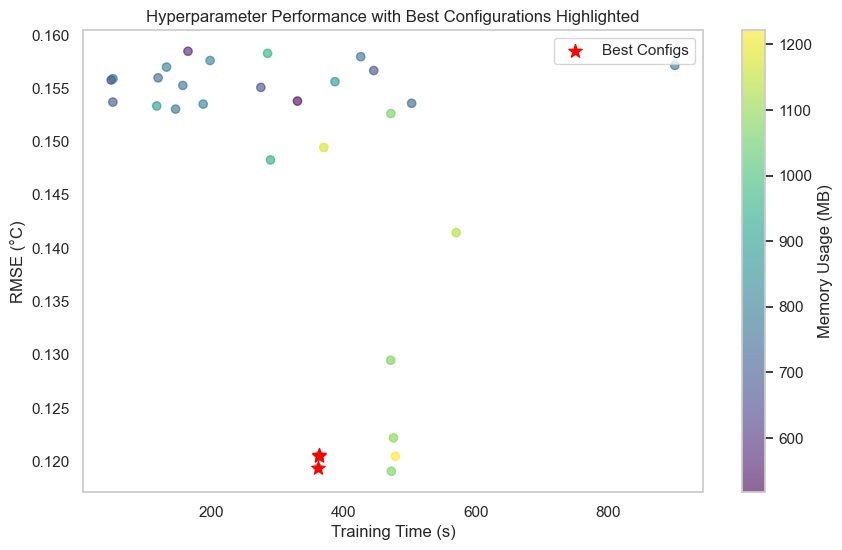

In [15]:
# Plot all trials with best ones highlighted
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results['training_time'], results['rmse'],
                     c=results['memory_mb'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Memory Usage (MB)')

# Highlight best configurations
best_idx = best_configs.index
plt.scatter(results.loc[best_idx, 'training_time'],
           results.loc[best_idx, 'rmse'],
           c='red', s=100, marker='*', label='Best Configs')

plt.xlabel('Training Time (s)')
plt.ylabel('RMSE (°C)')
plt.title('Hyperparameter Performance with Best Configurations Highlighted')
plt.legend()
plt.grid()
plt.show()

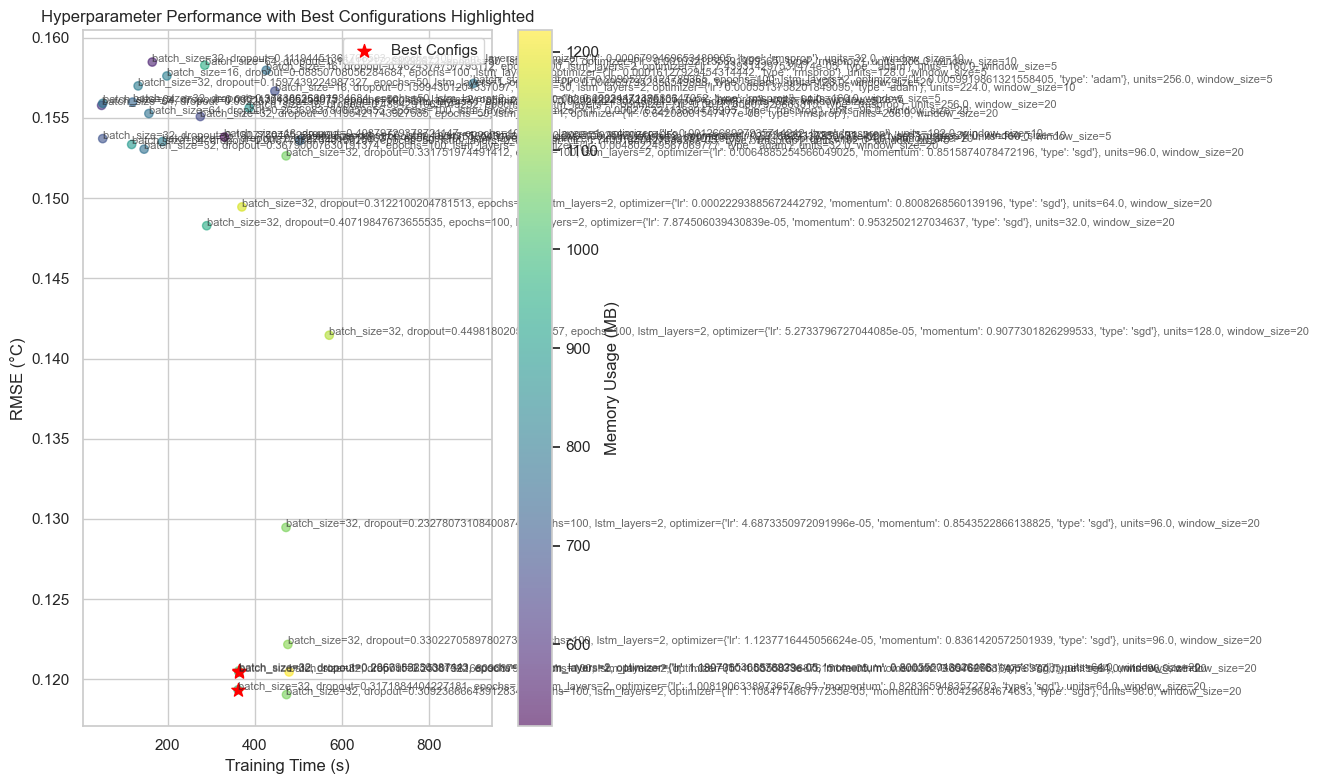

In [16]:
import ast
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Scatter plot
scatter = plt.scatter(results['training_time'], results['rmse'],
                      c=results['memory_mb'], cmap='viridis', alpha=0.6)

plt.colorbar(scatter, label='Memory Usage (MB)')

# Highlight best configurations
best_idx = best_configs.index
plt.scatter(results.loc[best_idx, 'training_time'],
            results.loc[best_idx, 'rmse'],
            c='red', s=100, marker='*', label='Best Configs')

# Annotate each point with its params (truncated for clarity)
for i, row in results.iterrows():
    try:
        params = ast.literal_eval(row['params']) if isinstance(row['params'], str) else row['params']
        short_label = ', '.join(f'{k}={v}' for k, v in params.items())
    except Exception:
        short_label = str(row['params'])[:30] + '...'

    plt.text(row['training_time'], row['rmse'], short_label, fontsize=8, alpha=0.7)

plt.xlabel('Training Time (s)')
plt.ylabel('RMSE (°C)')
plt.title('Hyperparameter Performance with Best Configurations Highlighted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


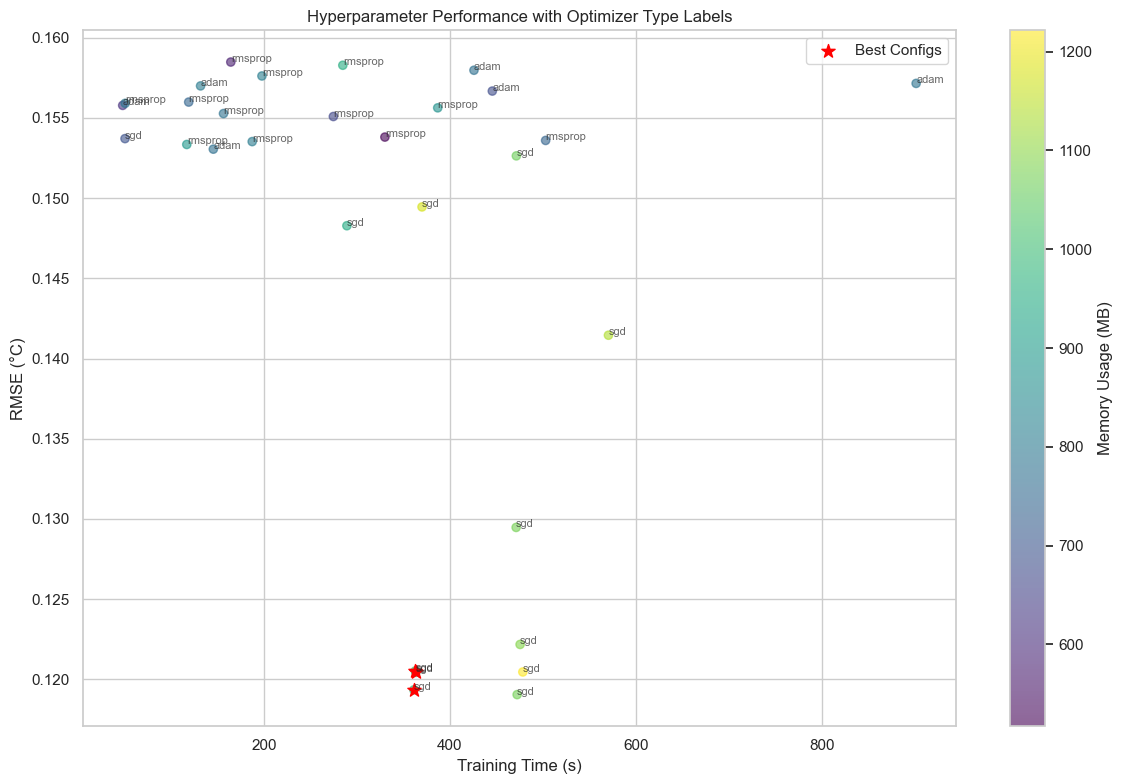

In [17]:
import ast
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Scatter plot of all results
scatter = plt.scatter(results['training_time'], results['rmse'],
                      c=results['memory_mb'], cmap='viridis', alpha=0.6)

plt.colorbar(scatter, label='Memory Usage (MB)')

# Highlight best configurations
best_idx = best_configs.index
plt.scatter(results.loc[best_idx, 'training_time'],
            results.loc[best_idx, 'rmse'],
            c='red', s=100, marker='*', label='Best Configs')

# Annotate each point with optimizer['type']
for i, row in results.iterrows():
    try:
        # Convert params string to dictionary if needed
        params = ast.literal_eval(row['params']) if isinstance(row['params'], str) else row['params']
        opt_type = params.get('optimizer', {}).get('type', 'N/A')
    except Exception:
        opt_type = 'N/A'

    # Add text label next to point
    plt.text(row['training_time'], row['rmse'], str(opt_type), fontsize=8, alpha=0.7)

plt.xlabel('Training Time (s)')
plt.ylabel('RMSE (°C)')
plt.title('Hyperparameter Performance with Optimizer Type Labels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


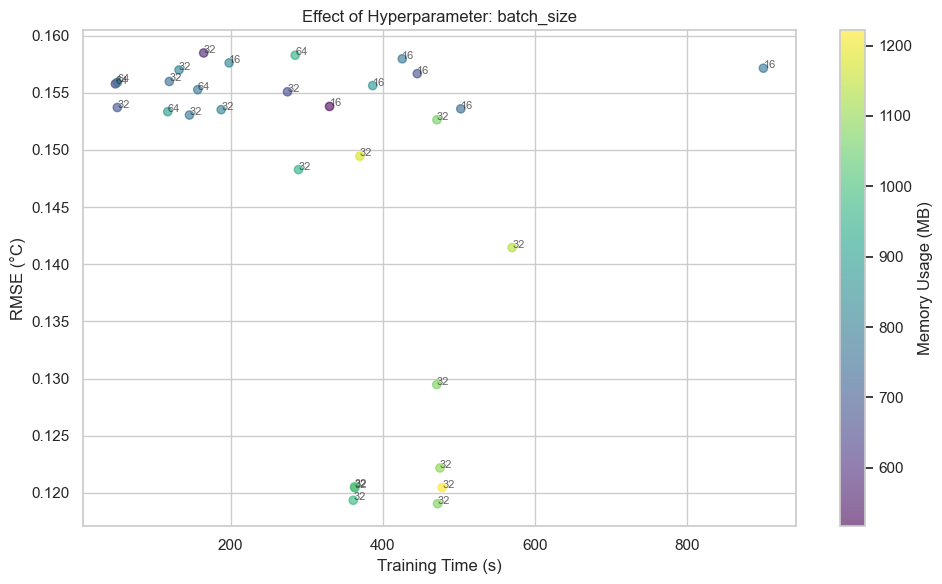

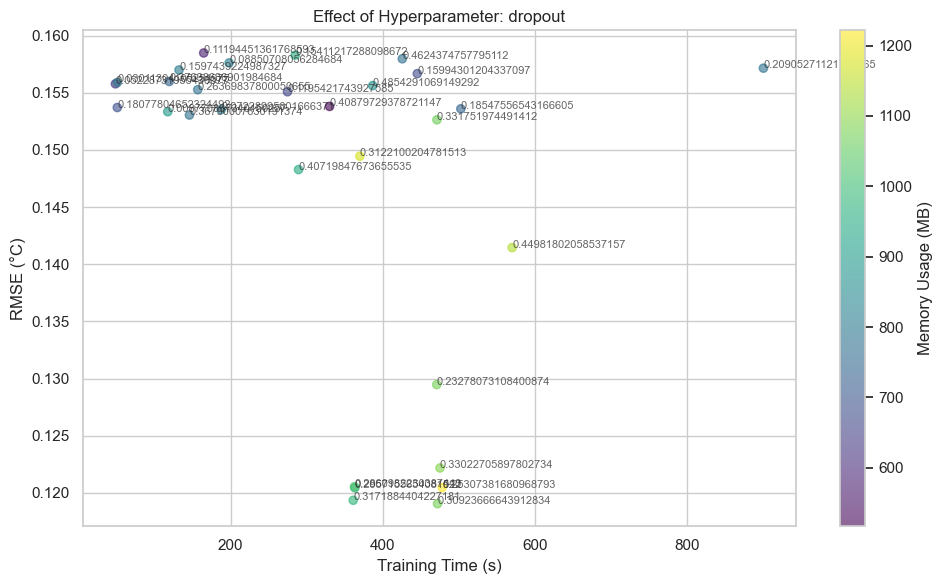

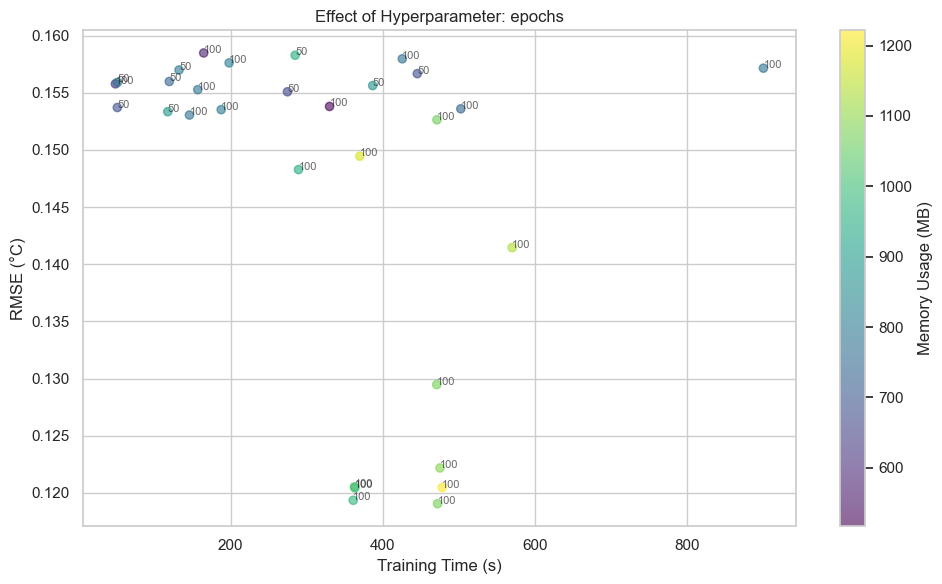

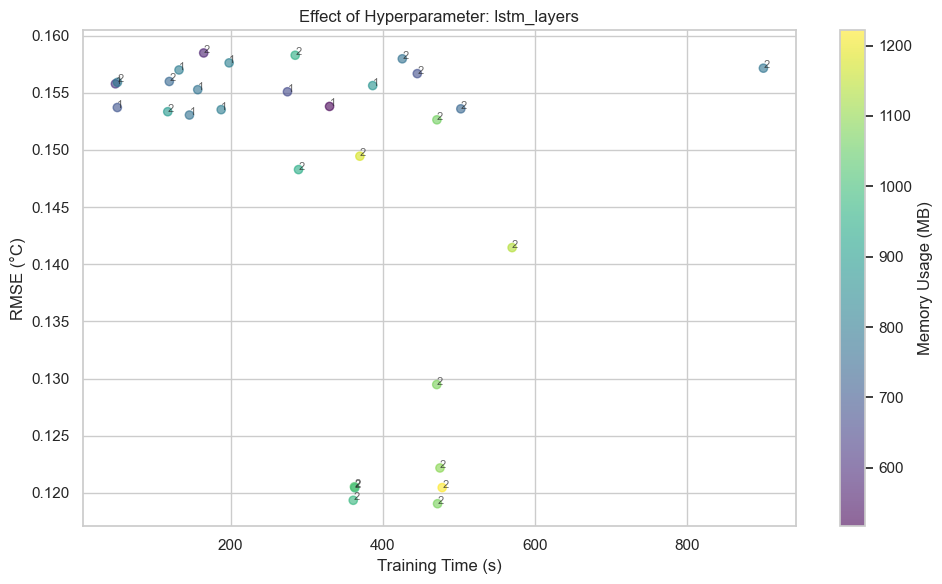

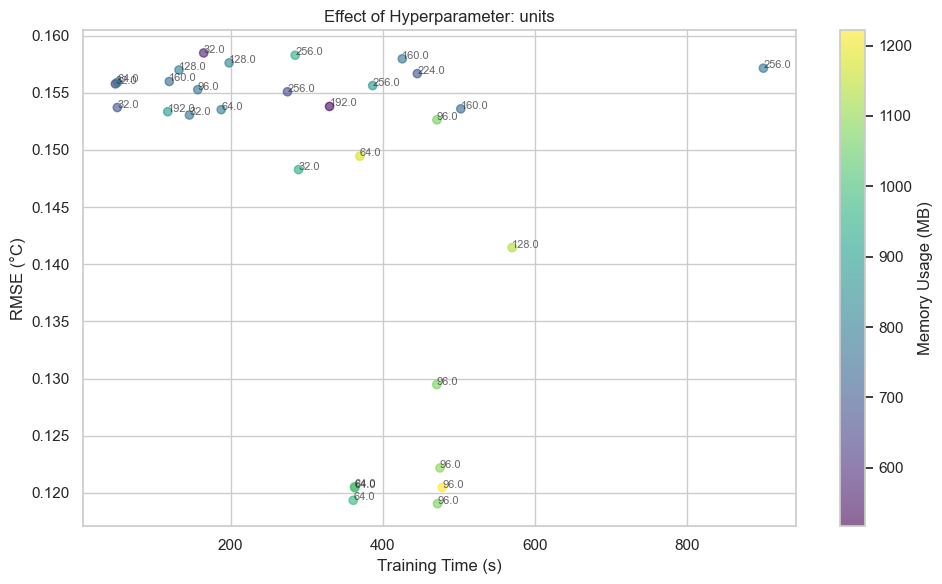

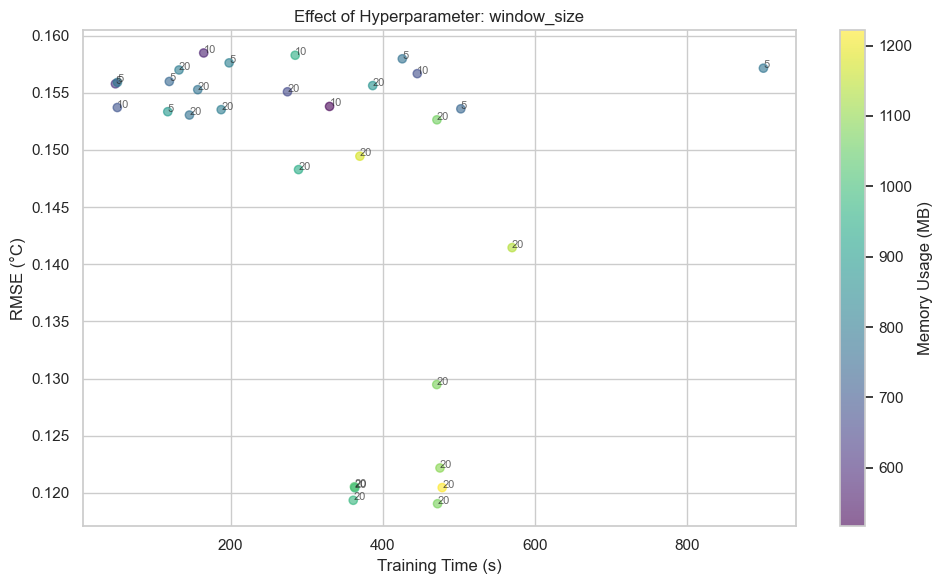

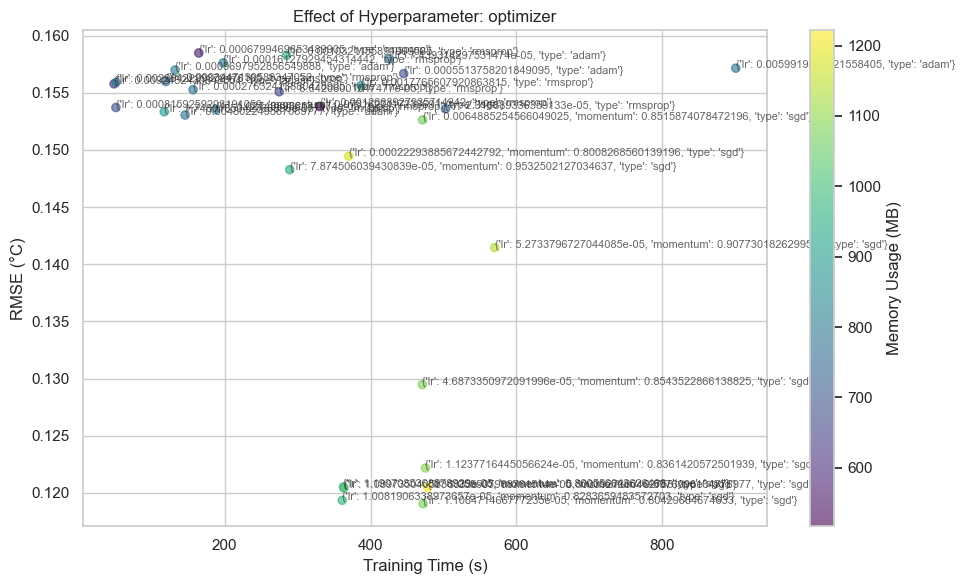

In [18]:
import ast
import matplotlib.pyplot as plt

# Parameters to plot
param_keys = ['batch_size', 'dropout', 'epochs', 'lstm_layers', 'units', 'window_size','optimizer']

# Pre-process: extract params from each row into new DataFrame columns
for param in param_keys + ['optimizer']:
    results[param] = results['params'].apply(lambda x: ast.literal_eval(x)[param] if isinstance(x, str) else x[param])

# Now extract optimizer['type'] as well (optional for coloring or extra labeling)
results['optimizer_type'] = results['optimizer'].apply(lambda opt: opt['type'] if isinstance(opt, dict) and 'type' in opt else 'N/A')

# Plot each parameter
for param in param_keys:
    plt.figure(figsize=(10, 6))

    scatter = plt.scatter(results['training_time'], results['rmse'],
                          c=results['memory_mb'], cmap='viridis', alpha=0.6)

    plt.colorbar(scatter, label='Memory Usage (MB)')

    plt.xlabel('Training Time (s)')
    plt.ylabel('RMSE (°C)')
    plt.title(f'Effect of Hyperparameter: {param}')

    # Annotate each point with the parameter value
    for i, row in results.iterrows():
        plt.text(row['training_time'], row['rmse'], str(row[param]), fontsize=8, alpha=0.7)

    plt.grid(True)
    plt.tight_layout()
    plt.show()


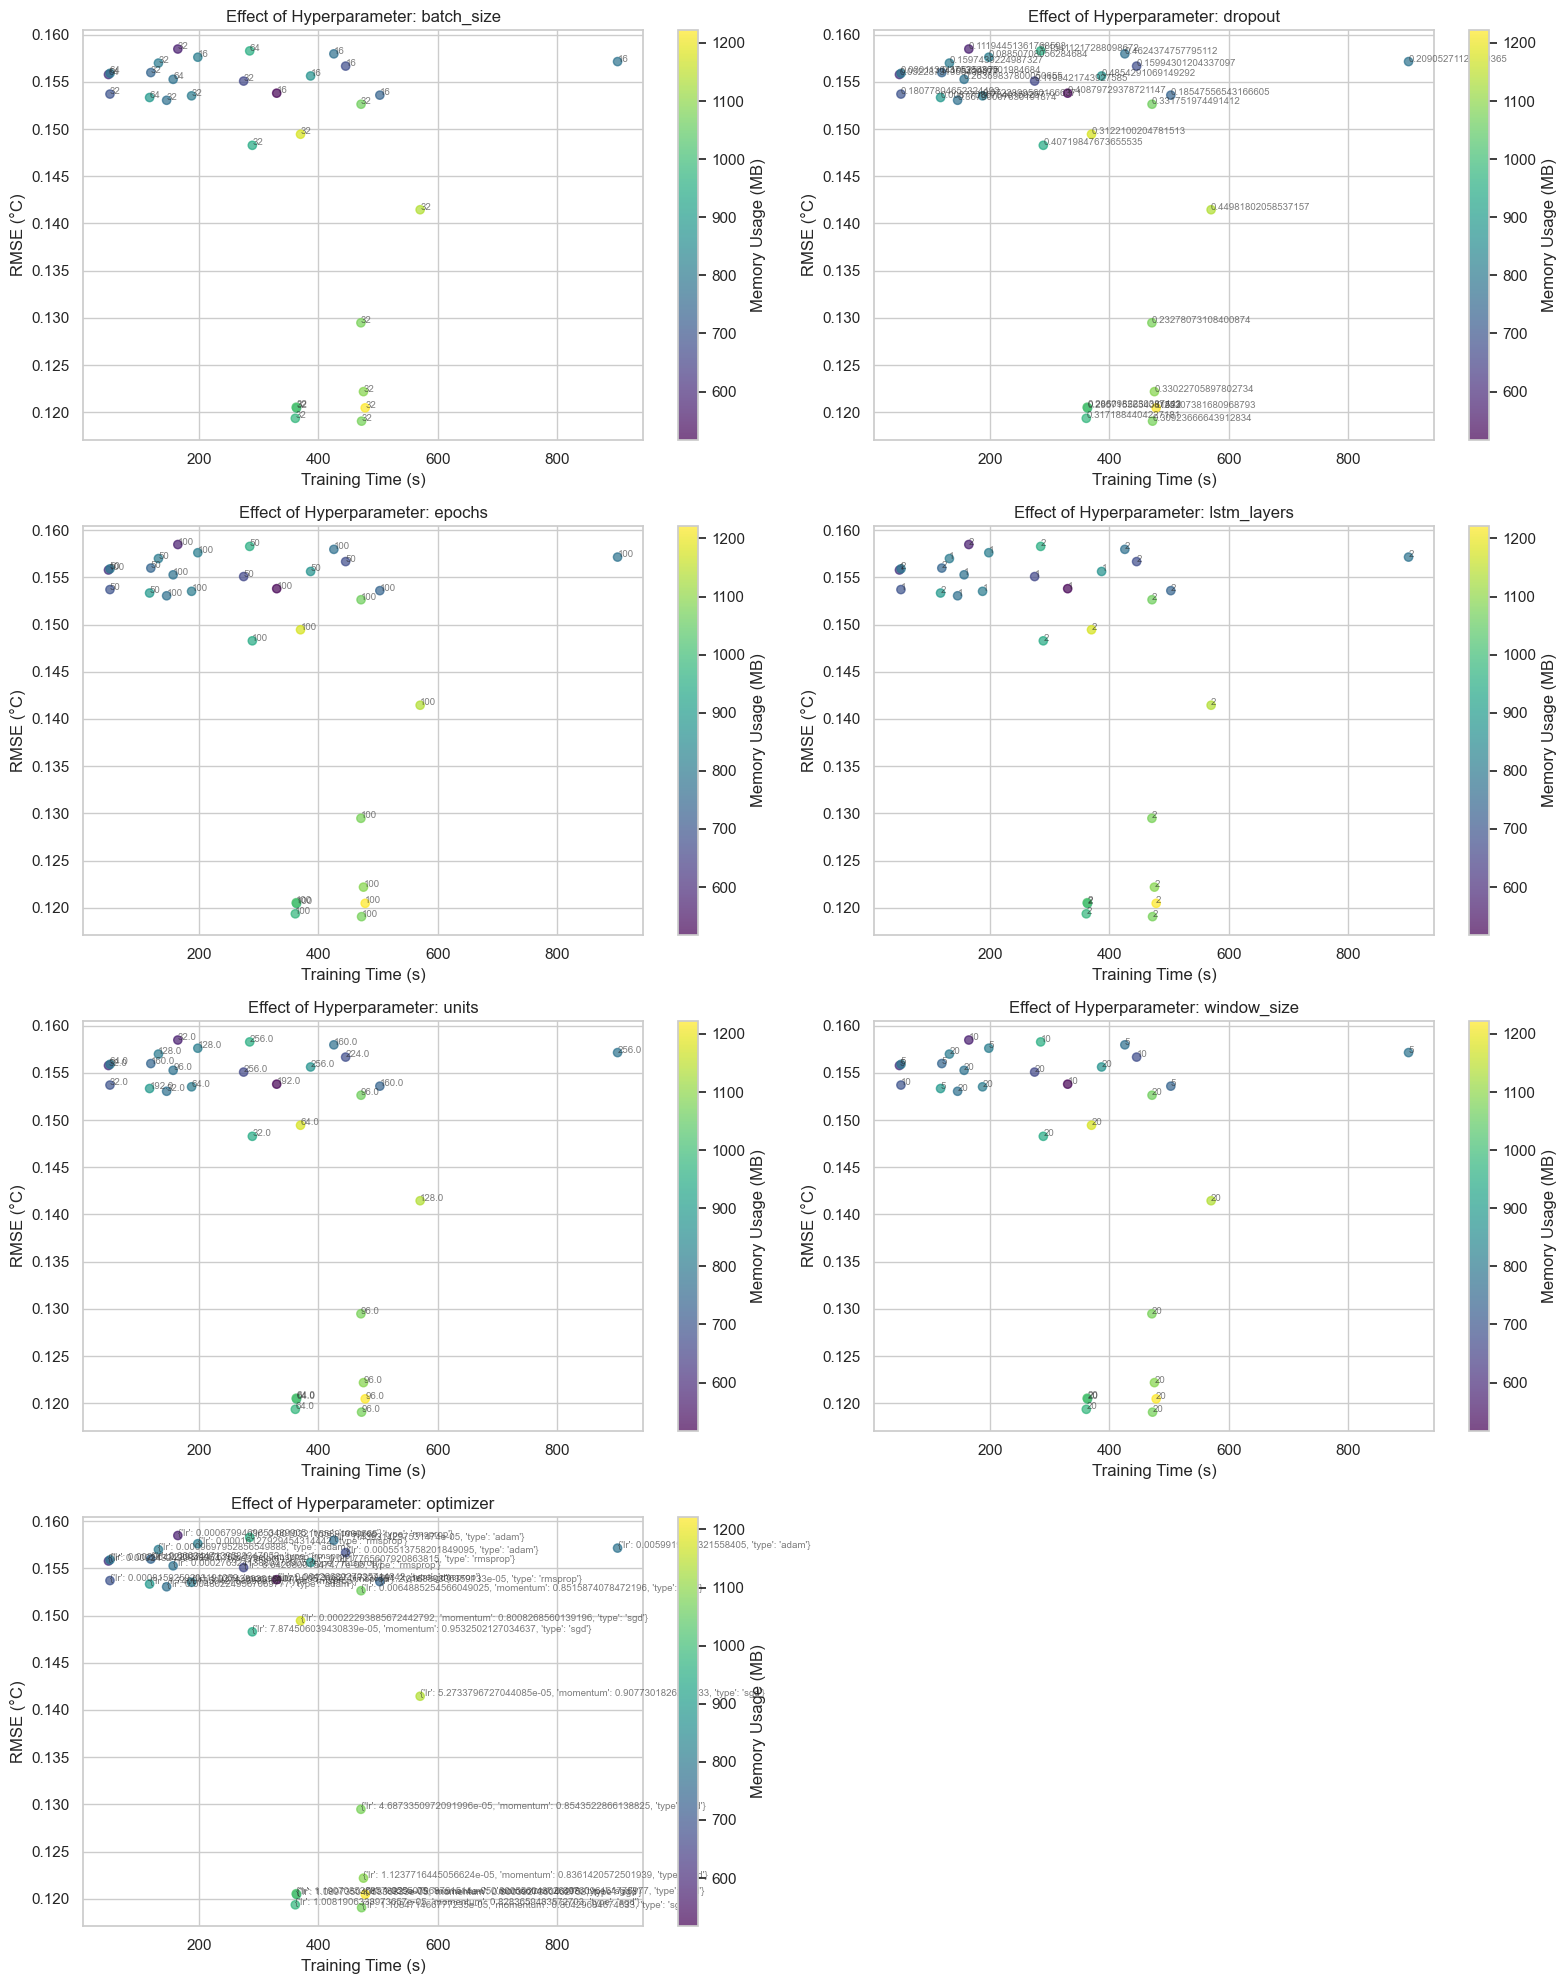

In [19]:
import ast
import matplotlib.pyplot as plt

# Parameters to plot
param_keys = ['batch_size', 'dropout', 'epochs', 'lstm_layers', 'units', 'window_size', 'optimizer']

# Parse parameter dictionary from string if needed
for param in param_keys:
    results[param] = results['params'].apply(lambda x: ast.literal_eval(x)[param] if isinstance(x, str) else x[param])

# Extract optimizer type (optional)
results['optimizer_type'] = results['optimizer'].apply(
    lambda opt: opt['type'] if isinstance(opt, dict) and 'type' in opt else 'N/A'
)

# Create a 4x2 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

# Plot each parameter
for idx, param in enumerate(param_keys):
    ax = axes[idx]

    # Scatter plot with color mapped to memory usage
    scatter = ax.scatter(results['training_time'], results['rmse'],
                         c=results['memory_mb'], cmap='viridis', alpha=0.7)

    ax.set_title(f'Effect of Hyperparameter: {param}')
    ax.set_xlabel('Training Time (s)')
    ax.set_ylabel('RMSE (°C)')
    ax.grid(True)

    # Annotate each point with param value
    for i, row in results.iterrows():
        ax.text(row['training_time'], row['rmse'], str(row[param]), fontsize=7, alpha=0.6)

    # Add individual colorbar for each subplot
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Memory Usage (MB)')

# Hide unused subplot if param_keys < 8
if len(param_keys) < len(axes):
    for j in range(len(param_keys), len(axes)):
        fig.delaxes(axes[j])  # remove unused axes

plt.tight_layout()
plt.show()


In [20]:
results

params optimizer_type  \
0   {'batch_size': 16, 'dropout': 0.40879729378721...        rmsprop   
1   {'batch_size': 32, 'dropout': 0.11194451361768...        rmsprop   
2   {'batch_size': 64, 'dropout': 0.05228731955430...           adam   
3   {'batch_size': 32, 'dropout': 0.11954217439275...        rmsprop   
4   {'batch_size': 16, 'dropout': 0.15994301204337...           adam   
5   {'batch_size': 32, 'dropout': 0.18077804652324...            sgd   
6   {'batch_size': 32, 'dropout': 0.37638636901984...        rmsprop   
7   {'batch_size': 32, 'dropout': 0.36790007630191...           adam   
8   {'batch_size': 16, 'dropout': 0.20905271121789...           adam   
9   {'batch_size': 16, 'dropout': 0.18547556543166...        rmsprop   
10  {'batch_size': 16, 'dropout': 0.46243747577951...           adam   
11  {'batch_size': 64, 'dropout': 0.26369837800050...        rmsprop   
12  {'batch_size': 32, 'dropout': 0.15974392249873...           adam   
13  {'batch_size': 16, 'dropout': 0.08850708056284...        rmsprop   
14  {'batch_size': 64, 'dropout': 0.03011304105254...        rmsprop   
15  {'batch_size': 32, 'dropout': 0.07228995601666...        rmsprop   
16  {'batch_size': 16, 'dropout': 0.48542910691492...        rmsprop   
17  {'batch_size': 64, 'dropout': 0.00877086734015...        rmsprop   
18  {'batch_size': 64, 'dropout': 0.15411217288098...        rmsprop   
19  {'batch_size': 32, 'dropout': 0.40719847673655...            sgd   
20  {'batch_size': 32, 'dropout': 0.31718844042271...            sgd   
21  {'batch_size': 32, 'dropout': 0.29571556540815...            sgd   
22  {'batch_size': 32, 'dropout': 0.28609822303874...            sgd   
23  {'batch_size': 32, 'dropout': 0.30923666643912...            sgd   
24  {'batch_size': 32, 'dropout': 0.23278073108400...            sgd   
25  {'batch_size': 32, 'dropout': 0.33175197449141...            sgd   
26  {'batch_size': 32, 'dropout': 0.33022705897802...            sgd   
27  {'batch_size': 32, 'dropout': 0.44981802058537...            sgd   
28  {'batch_size': 32, 'dropout': 0.31221002047815...            sgd   
29  {'batch_size': 32, 'dropout': 0.25307381680968...            sgd   

        rmse  training_time    memory_mb  stability  final_val_loss  \
0   0.153799     330.068304   517.058594   0.000050        0.001599   
1   0.158476     164.484135   572.441406   0.000044        0.001584   
2   0.155774      48.315219   615.929688   0.000057        0.001543   
3   0.155081     274.700843   665.367188   0.000030        0.002006   
4   0.156667     445.507951   677.843750   0.000039        0.001717   
5   0.153704      50.816659   692.007812   0.000017        0.002204   
6   0.155981     119.238909   740.277344   0.000073        0.001890   
7   0.153046     145.707797   770.492188   0.000124        0.001577   
8   0.157145     900.923638   782.281250   0.000085        0.001625   
9   0.153590     502.788603   739.289062   0.000017        0.002648   
10  0.157964     425.782590   770.734375   0.000057        0.001620   
11  0.155265     156.637440   776.621094   0.000085        0.001792   
12  0.156989     131.997051   805.089844   0.000095        0.001559   
13  0.157608     197.936599   811.894531   0.000044        0.001700   
14  0.155903      50.981364   794.851562   0.000274        0.001775   
15  0.153517     187.487240   808.539062   0.000012        0.002419   
16  0.155621     386.841115   871.367188   0.000050        0.001567   
17  0.153338     117.185299   890.730469   0.000013        0.002969   
18  0.158275     284.845754   955.761719   0.000295        0.002583   
19  0.148275     289.237580   943.746094   0.000016        0.003264   
20  0.119353     361.233670   979.019531   0.000048        0.011826   
21  0.120443     363.379642   976.117188   0.000029        0.009530   
22  0.120533     362.799025  1021.402344   0.000047        0.009062   
23  0.119053     472.176802  1071.875000   0.000049        0.012026   
24  0.129473     471.109587  1073.98437

In [21]:
import pandas as pd

# Assuming results is a list of dicts like:
# results = [{'params': ..., 'rmse': ..., 'training_time': ..., ...}, {...}, ...]

# Step 1: Convert to DataFrame
df = pd.DataFrame(results)

# Step 2: Get the row with the minimum RMSE
min_rmse_row = df.loc[df['rmse'].idxmin()]
# Or keep it as a one-row DataFrame:
min_rmse_df = df.loc[[df['rmse'].idxmin()]]

# Print the result
print(min_rmse_df)

                                               params optimizer_type  \
23  {'batch_size': 32, 'dropout': 0.30923666643912...            sgd   

        rmse  training_time  memory_mb  stability  final_val_loss  \
23  0.119053     472.176802   1071.875   0.000049        0.012026   

    composite_score  batch_size   dropout  epochs  lstm_layers  units  \
23         0.191857          32  0.309237     100            2   96.0   

    window_size                                          optimizer  
23           20  {'lr': 1.108471466777235e-05, 'momentum': 0.80...  


In [22]:
print(min_rmse_df["params"])

23    {'batch_size': 32, 'dropout': 0.30923666643912...
Name: params, dtype: object


In [23]:
import ast

# Extract the string version of the dictionary
params_str = min_rmse_df['params'].values[0]

# Convert the string to a dictionary
params_dict = ast.literal_eval(params_str)

# Now you can iterate through the dictionary
for key, value in params_dict.items():
    print(f"{key}: {value}")


batch_size: 32
dropout: 0.30923666643912834
epochs: 100
lstm_layers: 2
optimizer: {'lr': 1.108471466777235e-05, 'momentum': 0.80429684674633, 'type': 'sgd'}
units: 96.0
window_size: 20


## Extracting the Absolute Best Configuration

In [24]:
# Get the single best configuration
best_config = results.loc[results['composite_score'].idxmin()]

print("\n=== BEST HYPERPARAMETER CONFIGURATION ===")
print(f"RMSE: {best_config['rmse']:.2f}°C")
print(f"Training Time: {best_config['training_time']:.1f}s")
print(f"Memory Usage: {best_config['memory_mb']:.1f}MB")
print(f"Stability (σ of last val_loss): {best_config['stability']:.4f}")
print("\nHyperparameters:")
print(best_config['params'])


=== BEST HYPERPARAMETER CONFIGURATION ===
RMSE: 0.12°C
Training Time: 361.2s
Memory Usage: 979.0MB
Stability (σ of last val_loss): 0.0000

Hyperparameters:
{'batch_size': 32, 'dropout': 0.3171884404227181, 'epochs': 100, 'lstm_layers': 2, 'optimizer': {'lr': 1.0081906338973657e-05, 'momentum': 0.8283659483572703, 'type': 'sgd'}, 'units': 64.0, 'window_size': 20}


## Saving the Best Configuration

In [25]:
# Save the best configuration to a JSON file
best_config.to_json('best_hyperparameters.json')

print("\nBest configuration saved to 'best_hyperparameters.json'")


Best configuration saved to 'best_hyperparameters.json'


In [26]:
import pandas as pd

# Select the columns
metric_cols = ['rmse', 'training_time', 'memory_mb']
param_cols = ['batch_size', 'dropout', 'epochs', 'lstm_layers', 'units', 'window_size', 'optimizer_type']
results['learning_rate'] = results['optimizer'].apply(lambda opt: opt.get('lr') if isinstance(opt, dict) else None)
param_cols.append('learning_rate')

# Generate matrix tables
tables = []
for _, row in results.iterrows():
    data = {
        'Metric': ['RMSE (°C)', 'Training Time (s)', 'Memory (MB)']
    }
    for param in param_cols:
        val = row[param]
        data[param.replace('_', ' ').title()] = [val] * 3  # Repeat for each metric row

    data['Value'] = [round(row['rmse'], 3), round(row['training_time'], 2), round(row['memory_mb'], 2)]
    df = pd.DataFrame(data)
    df.set_index('Metric', inplace=True)
    tables.append(df)

# Print all tables
for i, table in enumerate(tables, 1):
    print(f"\n### Experiment {i}")
    print(table.to_markdown())



### Experiment 1
| Metric            |   Batch Size |   Dropout |   Epochs |   Lstm Layers |   Units |   Window Size | Optimizer Type   |   Learning Rate |   Value |
|:------------------|-------------:|----------:|---------:|--------------:|--------:|--------------:|:-----------------|----------------:|--------:|
| RMSE (°C)         |           16 |  0.408797 |      100 |             1 |     192 |            10 | rmsprop          |      0.00126689 |   0.154 |
| Training Time (s) |           16 |  0.408797 |      100 |             1 |     192 |            10 | rmsprop          |      0.00126689 | 330.07  |
| Memory (MB)       |           16 |  0.408797 |      100 |             1 |     192 |            10 | rmsprop          |      0.00126689 | 517.06  |

### Experiment 2
| Metric            |   Batch Size |   Dropout |   Epochs |   Lstm Layers |   Units |   Window Size | Optimizer Type   |   Learning Rate |   Value |
|:------------------|-------------:|----------:|---------:|-----------

## Composite Score vs. Each Hyperparameter

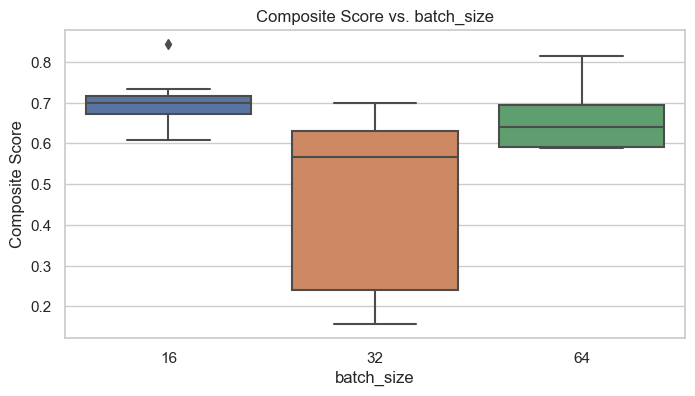

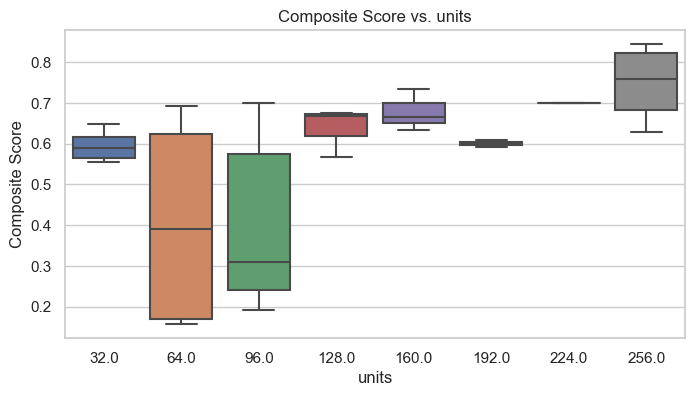

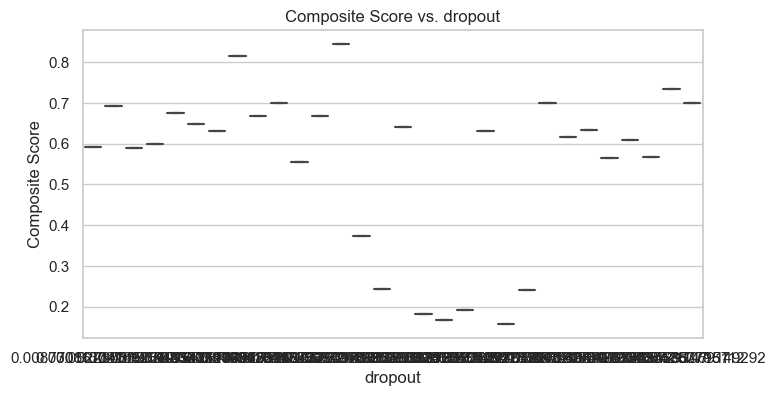

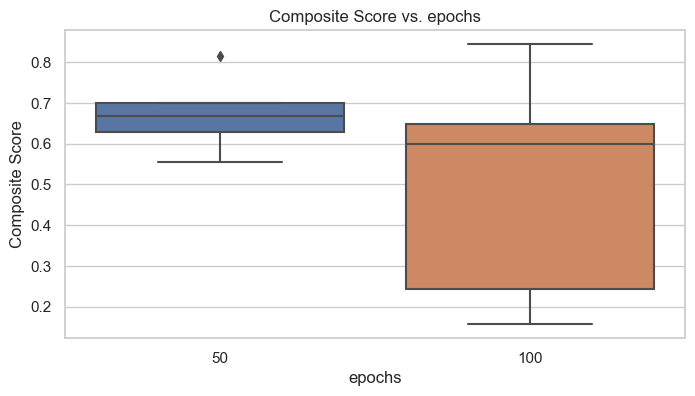

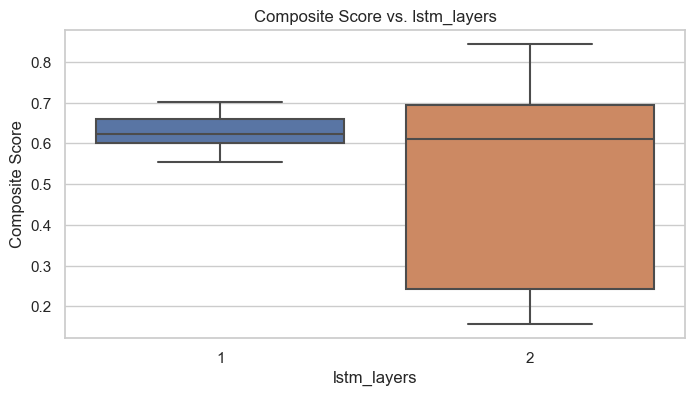

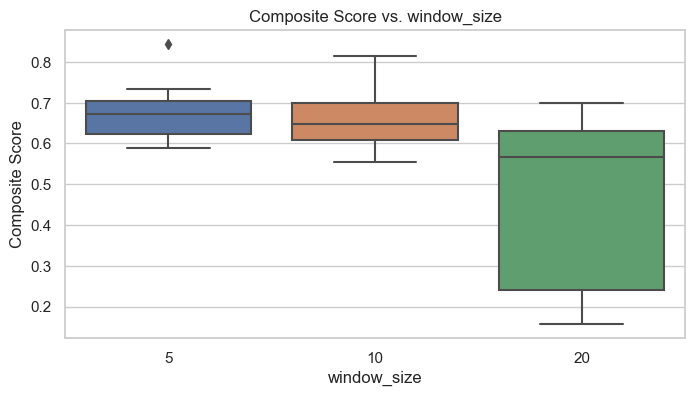

In [27]:
for param in ['batch_size', 'units', 'dropout', 'epochs', 'lstm_layers', 'window_size']:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=results[param], y=results['composite_score'])
    plt.title(f"Composite Score vs. {param}")
    plt.xlabel(param)
    plt.ylabel("Composite Score")
    plt.show()


## Pair Plot (Scatterplot Matrix) Colored by Composite Score

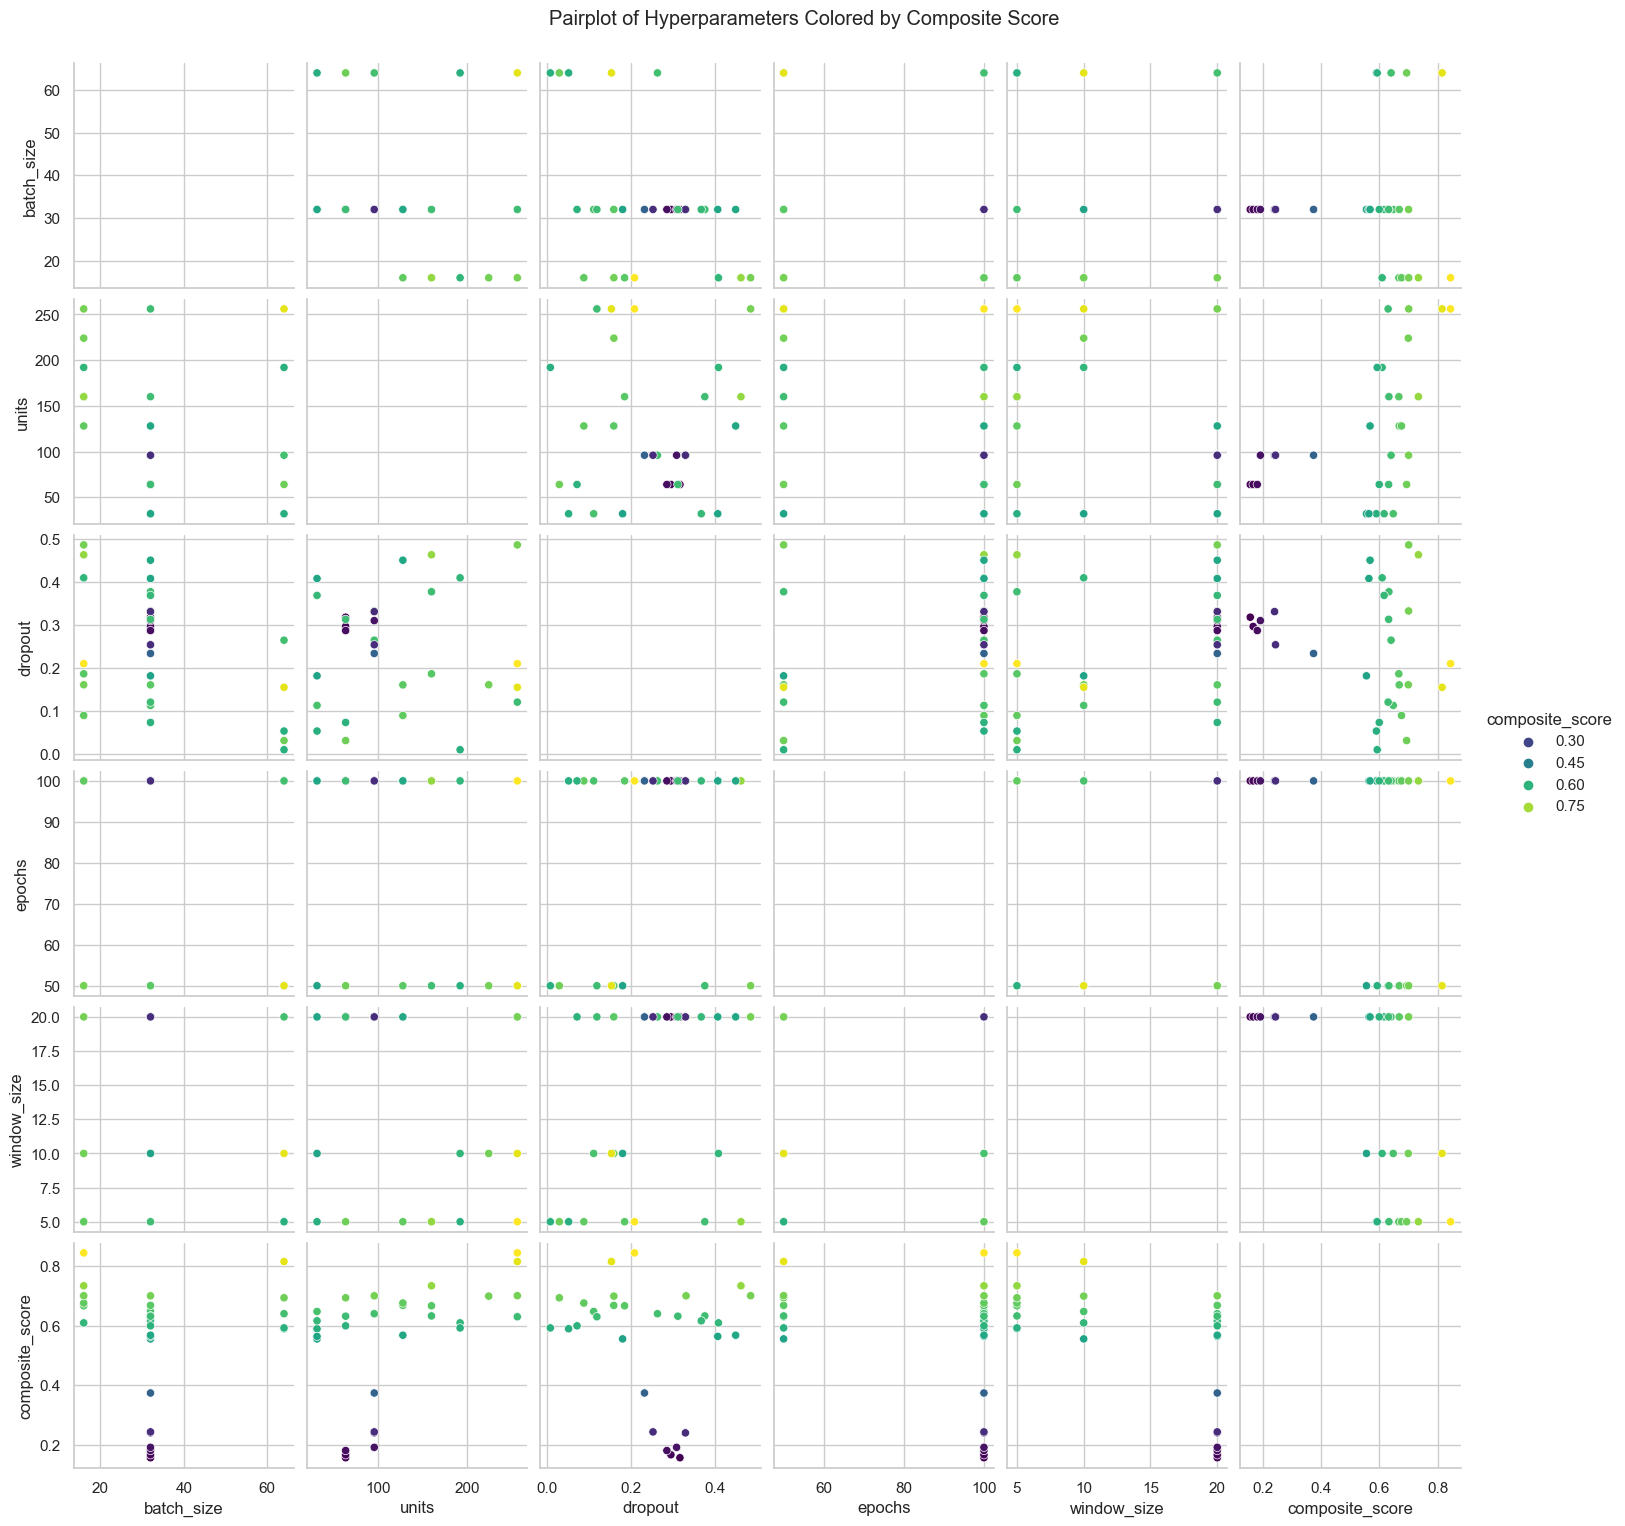

In [28]:
sns.pairplot(results,
             vars=['batch_size', 'units', 'dropout', 'epochs', 'window_size', 'composite_score'],
             kind='scatter',
             diag_kind='kde',
             hue='composite_score',
             palette='viridis')
plt.suptitle("Pairplot of Hyperparameters Colored by Composite Score", y=1.02)
plt.show()


In [29]:
import plotly.express as px
fig = px.scatter(results, x='training_time', y='rmse',
                 color='composite_score', size='memory_mb',
                 hover_data=['batch_size', 'units', 'dropout', 'epochs', 'lstm_layers', 'window_size'],
                 title="Interactive Plot: Training Time vs RMSE Colored by Composite Score")
fig.show()


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Supposons que results est déjà chargé et nettoyé comme avant
results['learning_rate'] = results['optimizer'].apply(lambda x: x.get('lr') if isinstance(x, dict) else None)

cols = ['batch_size', 'dropout', 'epochs', 'lstm_layers', 'units', 'window_size',
        'optimizer_type', 'learning_rate', 'rmse', 'training_time', 'memory_mb']

table_df = results[cols].copy()

table_df['dropout'] = table_df['dropout'].round(3)
table_df['learning_rate'] = table_df['learning_rate'].apply(lambda x: f"{x:.6f}" if x is not None else "N/A")
table_df['rmse'] = table_df['rmse'].round(3)
table_df['training_time'] = table_df['training_time'].round(2)
table_df['memory_mb'] = table_df['memory_mb'].round(2)
table_df['units'] = table_df['units'].astype(int)
table_df.insert(0, 'Expérience', range(1, len(table_df)+1))

fig, ax = plt.subplots(figsize=(16.5, 11.7))
ax.axis('off')

table = ax.table(cellText=table_df.values, colLabels=table_df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)

# Colonnes à colorier selon valeur et leur cmap
color_info = {
    'rmse': cm.Reds,           # rouge clair -> rouge foncé
    'training_time': cm.Blues, # bleu clair -> bleu foncé
    'memory_mb': cm.Greens     # vert clair -> vert foncé
}

# Fonction pour normaliser la colonne entre 0 et 1 pour la color map
def normalize_col(col):
    col_numeric = pd.to_numeric(col, errors='coerce')
    min_val = col_numeric.min()
    max_val = col_numeric.max()
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    return norm

# Préparer les normalisations par colonne
norms = {}
for col in color_info.keys():
    norms[col] = normalize_col(table_df[col])

# Colorier en-têtes (ligne 0) en gris clair
for col_name in color_info.keys():
    col_idx = table_df.columns.get_loc(col_name)
    table[(0, col_idx)].set_facecolor('#cccccc')
    table[(0, col_idx)].set_text_props(weight='bold')

# Colorier cellules selon valeur
for row_idx in range(1, len(table_df)+1):
    for col_name, cmap in color_info.items():
        col_idx = table_df.columns.get_loc(col_name)
        val = table_df.iloc[row_idx-1][col_name]
        if pd.isna(val):
            color = '#ffffff'  # blanc si NA
        else:
            normalized_val = norms[col_name](val)
            rgba = cmap(normalized_val)
            # Convertir RGBA en hex
            color = mcolors.to_hex(rgba)
        table[(row_idx, col_idx)].set_facecolor(color)

plt.savefig("tableau_hyperparametres_A3_colored_values.pdf", bbox_inches='tight')
plt.close()

print("PDF avec colonnes colorées selon valeur sauvegardé.")


PDF avec colonnes colorées selon valeur sauvegardé.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Supposons que results est déjà chargé et préparé comme avant
results['learning_rate'] = results['optimizer'].apply(lambda x: x.get('lr') if isinstance(x, dict) else None)

cols = ['batch_size', 'dropout', 'epochs', 'lstm_layers', 'units', 'window_size',
        'optimizer_type', 'learning_rate', 'rmse', 'training_time', 'memory_mb']

table_df = results[cols].copy()

table_df['dropout'] = table_df['dropout'].round(3)
table_df['learning_rate'] = table_df['learning_rate'].apply(lambda x: f"{x:.6f}" if x is not None else "N/A")
table_df['rmse'] = table_df['rmse'].round(3)
table_df['training_time'] = table_df['training_time'].round(2)
table_df['memory_mb'] = table_df['memory_mb'].round(2)
table_df['units'] = table_df['units'].astype(int)
table_df.insert(0, 'Expérience', range(1, len(table_df)+1))

fig, ax = plt.subplots(figsize=(16.5, 11.7))
ax.axis('off')

table = ax.table(cellText=table_df.values, colLabels=table_df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)

# Colonnes à traiter
metrics = ['rmse', 'training_time', 'memory_mb']

# Couleurs best/worst
color_best = '#c1f0c1'  # vert clair
color_worst = '#f4c7c3' # rouge clair

# Trouver index lignes best et worst pour chaque métrique
for metric in metrics:
    col_idx = table_df.columns.get_loc(metric)
    col_values = pd.to_numeric(table_df[metric], errors='coerce')

    # Index du meilleur (min)
    best_idx = col_values.idxmin()
    # Index du pire (max)
    worst_idx = col_values.idxmax()

    # +1 car la table matplotlib a la ligne 0 pour les en-têtes
    table[(best_idx+1, col_idx)].set_facecolor(color_best)
    table[(worst_idx+1, col_idx)].set_facecolor(color_worst)

# Colorer les en-têtes en gris clair et gras
for col_idx in range(len(table_df.columns)):
    table[(0, col_idx)].set_facecolor('#cccccc')
    table[(0, col_idx)].set_text_props(weight='bold')

plt.savefig("tableau_best_worst_config.pdf", bbox_inches='tight')
plt.close()

print("PDF avec meilleure et pire config colorées sauvegardé.")


PDF avec meilleure et pire config colorées sauvegardé.


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Préparation des données (supposons que results est déjà chargé)
results['learning_rate'] = results['optimizer'].apply(lambda x: x.get('lr') if isinstance(x, dict) else None)

cols = ['batch_size', 'dropout', 'epochs', 'lstm_layers', 'units', 'window_size',
        'optimizer_type', 'learning_rate', 'rmse', 'training_time', 'memory_mb', 'composite_score']

table_df = results[cols].copy()

# Arrondir et formater pour lisibilité
table_df['dropout'] = table_df['dropout'].round(3)
table_df['learning_rate'] = table_df['learning_rate'].apply(lambda x: f"{x:.6f}" if x is not None else "N/A")
table_df['rmse'] = table_df['rmse'].round(3)
table_df['training_time'] = table_df['training_time'].round(2)
table_df['memory_mb'] = table_df['memory_mb'].round(2)
table_df['units'] = table_df['units'].astype(int)
table_df['composite_score'] = table_df['composite_score'].round(4)
table_df.insert(0, 'Expérience', range(1, len(table_df)+1))

fig, ax = plt.subplots(figsize=(16.5, 11.7))  # A3 paysage
ax.axis('off')

# Créer le tableau (exclure 'composite_score' de l'affichage si tu veux)
display_df = table_df.drop(columns=['composite_score'])

table = ax.table(cellText=display_df.values,
                 colLabels=display_df.columns,
                 cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.2)

# Couleurs pour meilleure / pire config selon composite_score
color_best = '#c1f0c1'   # vert clair
color_worst = '#f4c7c3'  # rouge clair
header_color = '#cccccc' # gris clair

# Indices de la meilleure et pire config selon composite_score
best_idx = table_df['composite_score'].idxmin()
worst_idx = table_df['composite_score'].idxmax()

# Colorer les en-têtes
for col_idx in range(len(display_df.columns)):
    table[(0, col_idx)].set_facecolor(header_color)
    table[(0, col_idx)].set_text_props(weight='bold')

# Colorer ligne entière de la meilleure config
for col_idx in range(len(display_df.columns)):
    table[(best_idx+1, col_idx)].set_facecolor(color_best)

# Colorer ligne entière de la pire config
for col_idx in range(len(display_df.columns)):
    table[(worst_idx+1, col_idx)].set_facecolor(color_worst)

plt.savefig("tableau_best_worst_composite_score.pdf", bbox_inches='tight')
plt.close()

print("PDF sauvegardé avec meilleure et pire configuration selon composite_score.")


PDF sauvegardé avec meilleure et pire configuration selon composite_score.
